In [1]:
import numpy as np
import pandas as pd

import datafoobars as dfb

In [2]:
old_raw_data = dfb.import_train_data()

old_raw_data.shape

(87642, 65)

In [3]:
old_raw_data["Position"] = dfb.extract_positions(old_raw_data)

old_raw_data = dfb.drop_positions(old_raw_data, ["RES", "SUB"])

old_raw_data = dfb.drop_personal_data(old_raw_data)
old_raw_data = dfb.drop_goalkeeper_data(old_raw_data)
old_raw_data = dfb.drop_categorical_data(old_raw_data, dropposition=False)
old_raw_data.drop("Overall", axis=1, inplace=True)
old_raw_data.dropna(inplace=True)
old_raw_data.shape

(31115, 29)

In [4]:
old_raw_data["Position"] = dfb.map_positions(old_raw_data["Position"])

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

X = old_raw_data.drop("Position", axis=1)
y = old_raw_data["Position"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [7]:
y_pred = rfc.predict(X_test)

rfc_accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Defender       0.92      0.95      0.93      2430
  Midfielder       0.85      0.88      0.86      2628
     Striker       0.87      0.75      0.81      1165

    accuracy                           0.88      6223
   macro avg       0.88      0.86      0.87      6223
weighted avg       0.88      0.88      0.88      6223


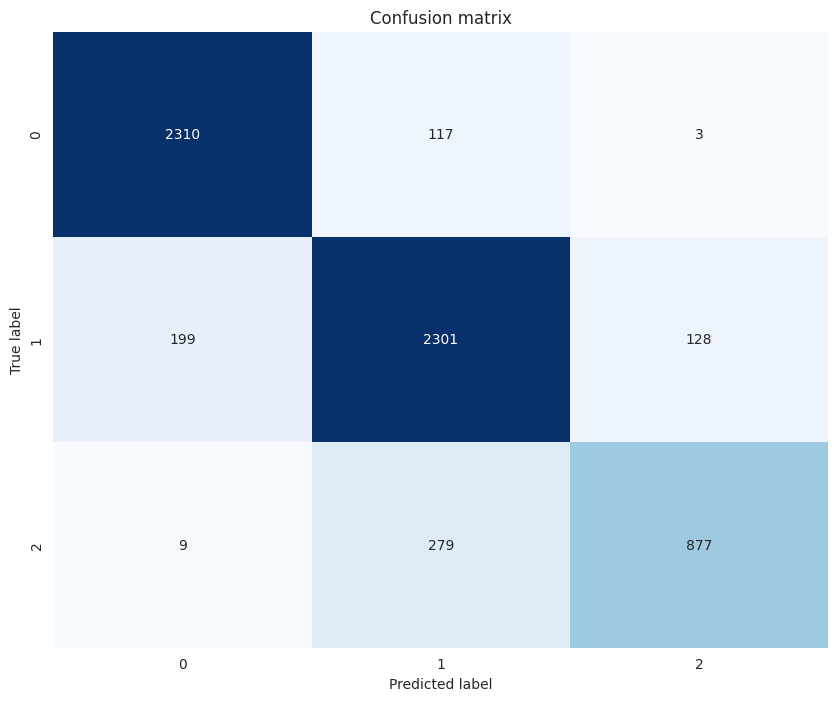

In [8]:
dfb.make_conf_matrix(y_test, y_pred)

In [9]:
pred_data = pd.read_csv("data/FIFA22_official_data.csv")

pred_data["Position"] = dfb.extract_positions(pred_data)

pred_data = dfb.drop_positions(pred_data, ["SUB", "RES"])

pred_data = dfb.drop_personal_data(pred_data)
pred_data = dfb.drop_goalkeeper_data(pred_data)
pred_data = dfb.drop_categorical_data(pred_data, dropposition=False)
pred_data.drop("Overall", axis=1, inplace=True)

pred_data.dropna(inplace=True)
pred_data.shape

(6133, 29)

In [10]:
pred_data["Position"] = dfb.map_positions(pred_data["Position"])

In [11]:
X_pred = pred_data.drop("Position", axis=1)
labels = pred_data["Position"]

In [12]:
y_pred = rfc.predict(X_pred)
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

    Defender       0.93      0.93      0.93      2390
  Midfielder       0.79      0.88      0.83      2435
     Striker       0.86      0.70      0.77      1308

    accuracy                           0.86      6133
   macro avg       0.86      0.83      0.84      6133
weighted avg       0.86      0.86      0.86      6133


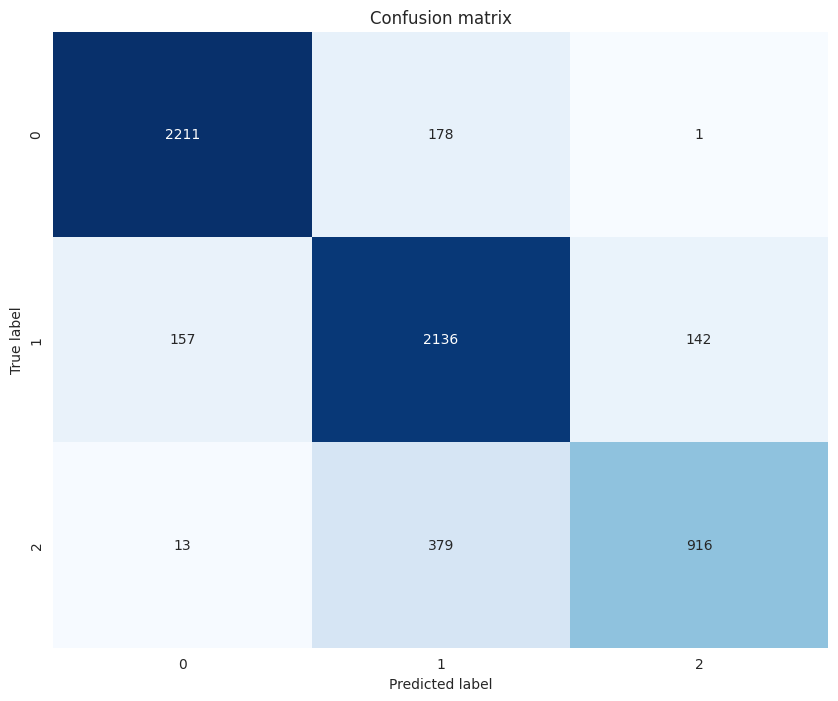

In [13]:
dfb.make_conf_matrix(labels, y_pred)

In [14]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

param_dist = {
    "n_estimators": [int(x) for x in np.linspace(start=200, stop=1600, num=100)],
    "max_depth": [int(x) for x in np.linspace(10, 70, num=10)]
}

random_search = RandomizedSearchCV(rfc, param_distributions=param_dist, n_iter=3, cv=4, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

print("Best Hyperparameters: ", random_search.best_params_)

best_rfc = random_search.best_estimator_
cv_scores = cross_val_score(best_rfc, X_train, y_train, cv=4)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores):.2f}%")

Fitting 4 folds for each of 3 candidates, totalling 12 fits
Best Hyperparameters:  {'n_estimators': 694, 'max_depth': 36}
Cross-Validation Scores: [0.88124699 0.8698377  0.87690824 0.88397879]
Mean CV Score: 0.88%


In [15]:
best_rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=36, n_estimators=694, random_state=42)

In [16]:
y_pred = best_rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Defender       0.92      0.95      0.93      2430
  Midfielder       0.85      0.88      0.86      2628
     Striker       0.87      0.75      0.80      1165

    accuracy                           0.88      6223
   macro avg       0.88      0.86      0.87      6223
weighted avg       0.88      0.88      0.88      6223


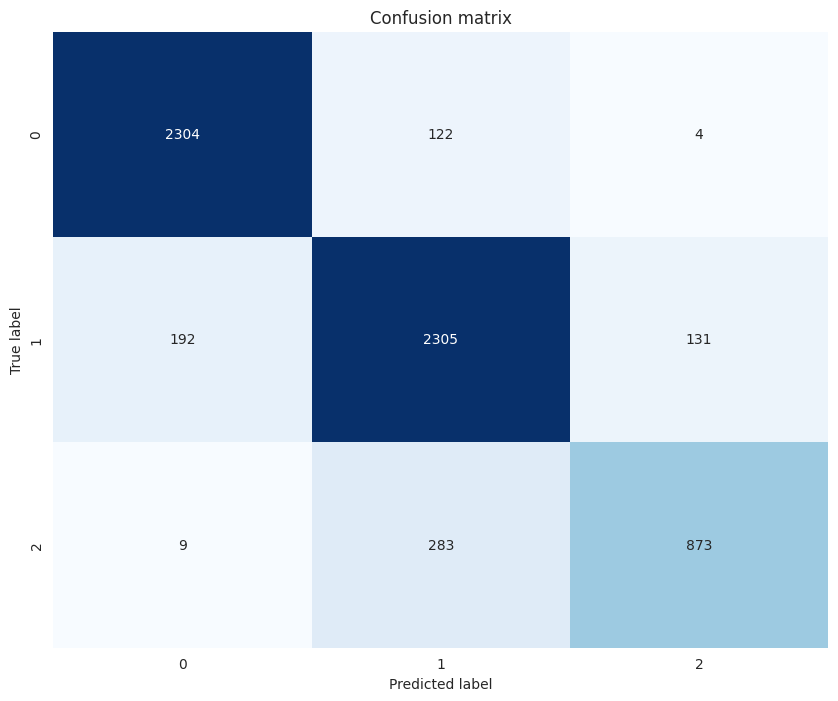

In [17]:
dfb.make_conf_matrix(y_test, y_pred)

In [18]:
y_pred = best_rfc.predict(X_pred)
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

    Defender       0.93      0.93      0.93      2390
  Midfielder       0.79      0.88      0.83      2435
     Striker       0.87      0.70      0.77      1308

    accuracy                           0.86      6133
   macro avg       0.86      0.84      0.85      6133
weighted avg       0.86      0.86      0.86      6133


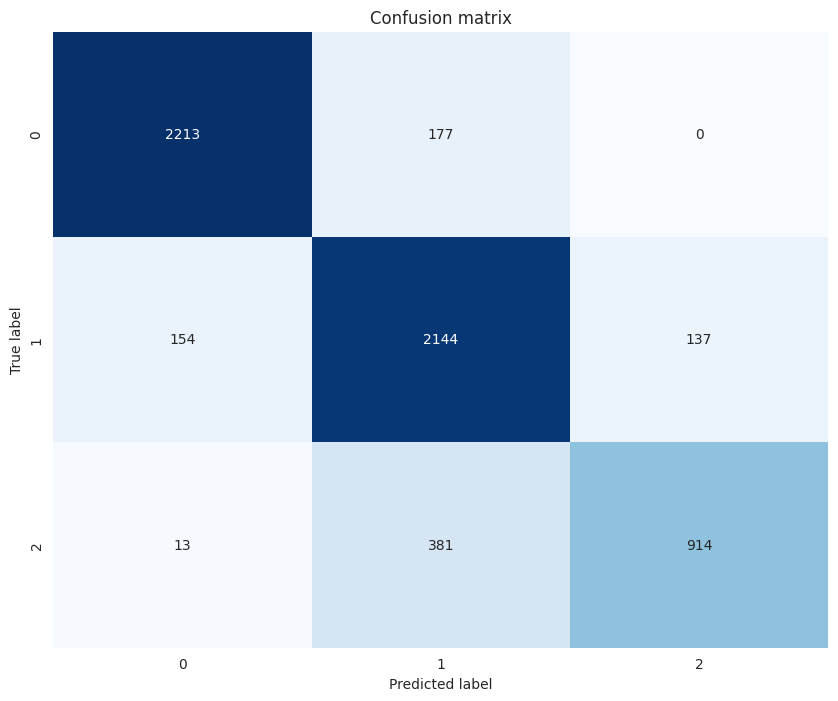

In [19]:
dfb.make_conf_matrix(labels, y_pred)